<img width="100" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# Checking Moura Costa equivalency claims

_by Freya Chay (CarbonPlan)_

The cool thing about physical equivalency claims is that they can be checked. With a simple example
below, we show how a Moura Costa ton-year "equivalency" claim fails to produce equivalent outcomes
from the standpoint of the atmosphere.


In [1]:
%load_ext watermark
%matplotlib inline

import math

import numpy as np
import matplotlib.pyplot as plt

import tonyear

from carbonplan import styles
styles.mpl.set_theme(style='carbonplan_light', font_scale=1.25)

In [2]:
%watermark -u -i -v -m -g -iv

Last updated: 2022-01-22T00:34:55.643141+00:00

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 7.30.1

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.4.0-1062-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

Git hash: f3fee74a823cc800507259b30d334107fb8b7d80

carbonplan: 0.4.0
tonyear   : 0.0.post80
numpy     : 1.22.0
matplotlib: 3.5.1



For our simple example, we imagine a project which temporarily stores 1 tCO2 for 20 years. We can
use the Moura Costa method with the parameters below to figure out how this project needs to scale
in order to offset the emission of 1tCO2.


In [3]:
joos_2013 = tonyear.get_baseline_curve("joos_2013")
time_horizon = 100
delay = 20
discount_rate = 0

When calculated with these parameters, Moura Costa makes the following physical equivalence claim:
storing 2.6 tCO2 for 20 years is equivalent to avoiding an emission altogether.


In [4]:
mc = tonyear.calculate_tonyears("mc", joos_2013, time_horizon, delay, discount_rate)
print("Cost of emission (ton-years): " + str(mc["baseline_atm_cost"]))
print("Benefit (ton-years):          " + str(mc["benefit"]))
print("Equivalence ratio:            " + str(mc["num_for_equivalence"]))

Cost of emission (ton-years): 52.36134634979823
Benefit (ton-years):          20.0
Equivalence ratio:            2.6180673174899116


We can check this equivalence claim by comparing atmospheric impact between:

1. the scenario where the project happens , scaled according to Moura Costa's equivalence ratio; and
2. the scenario where the project doesn't happen, scaledaccording to Moura Costa's equivalence
   ratio.


In [5]:
scaled_project_scenario = np.concatenate(
    (
        (mc["scenario"] * mc["num_for_equivalence"])[0 : delay + 1],
        (joos_2013 * mc["num_for_equivalence"])[0 : time_horizon - delay],
    )
)

scaled_counterfactual = (joos_2013 * mc["num_for_equivalence"])[0 : time_horizon + 1]

The difference between (2) - (1) can be understood as the benefit conferred by the temporary storage
project from the standpoint of the atmosphere.

So first we can ask, what impact did the atmosphere experience in the scaled project scenario? Since
we'll be making relative comparisons between (1), (2) and the original cost of an emission, we can
denomenate everything in ton-years rather than translating into cummulative radiative forcing.


Atmsopheric cost (ton-years): 113.96296683065066


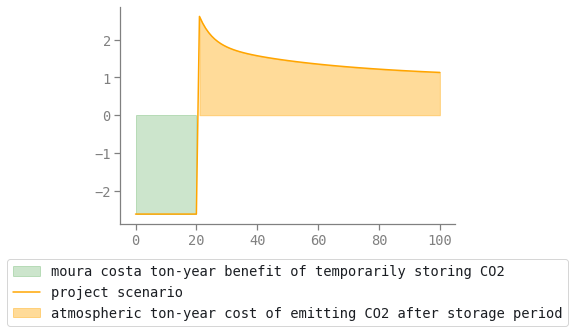

In [6]:
t = np.arange(time_horizon + 1)

plot = plt.fill_between(
    t[: len(scaled_project_scenario)],
    scaled_project_scenario,
    where=(np.array(t) <= delay),
    color="green",
    alpha=0.2,
    label="moura costa ton-year benefit of temporarily storing CO2",
)

plt.plot(scaled_project_scenario, color="orange", label="project scenario")
plot = plt.fill_between(
    t,
    scaled_project_scenario,
    where=(t > delay),
    color="orange",
    alpha=0.4,
    label="atmospheric ton-year cost of emitting CO2 after storage period",
)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5))

project_atm_cost = np.trapz(scaled_project_scenario[delay + 1 :])
print("Atmsopheric cost (ton-years): " + str(project_atm_cost))

Moura Costa calculates the benefit of temporary storage – and therefore the equivalency ratio –
simply by looking at the area in green (the ton-years of storage). However, the atmosphere
experiences a "cost" that is equivalent to the area in yellow (the atmospheric ton-years of CO2
emitted post-storage).

We can compare the atmospheric cost of the project scenario to the atmospheric cost of the
counterfactual where the project doesn't occur in order to calculate the benefit of the project from
the standpoint of the atmosphere.


Counterfactual atmospheric cost (ton-years): 137.08552957817645


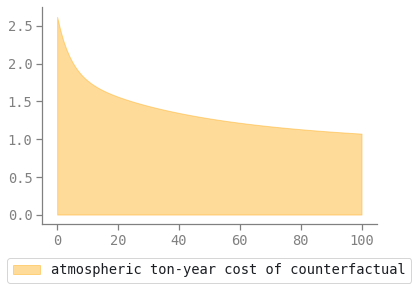

In [7]:
plot = plt.fill_between(
    t[: len(scaled_counterfactual)],
    scaled_counterfactual,
    color="orange",
    alpha=0.4,
    label="atmospheric ton-year cost of counterfactual",
)

plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3))

counterfactual_atm_cost = np.trapz(scaled_counterfactual)
print("Counterfactual atmospheric cost (ton-years): " + str(counterfactual_atm_cost))

With these two quantities calculated, we can calcuate the ton-year benefit of the scaled project
from the standpoint of the atmosphere.


In [8]:
atm_benefit = counterfactual_atm_cost - project_atm_cost

With that atmospheric benefit calculated, we can return to the orginial ton-year cost of an emission
that we were trying to offset to ask if the atmospheric benefit resulting from the scaled temporary
storage is equivalent to the atmospheric cost of the original emission.


In [9]:
print("Atmospheric benefit (ton-years): " + str(atm_benefit))
print("Cost of an emission (ton-years): " + str(mc["baseline_atm_cost"]))

Atmospheric benefit (ton-years): 23.12256274752579
Cost of an emission (ton-years): 52.36134634979823


The answer is, no! The temporary storage that the Moura Costa benefit claims is equivalent to the
original emission in fact only provides 44% of the benefit needed to "offset" the emission over the
100 year time horizon.


In [10]:
round(atm_benefit / mc["baseline_atm_cost"], 2)

0.44

## Moura Costa can value delay more than avoided

Moura Costa equivalency claims exhibit another physical inconsistency. Using the method results in
cases where delaying emission of 1 tCO2 can justify the emission of more than 1 tCO2. In other
words, for some parameter choices, the Moura Costa approach suggests that delaying emissions is more
valuable than avoiding emissions altogether. Brandão et al., 2013 describe this result using
geometric reasoning. With Moura Costa, the benefit of storing 1 tCO2 does not decrease with time --
1 tCO2 for 10 years? 10 ton-years. 50 years? 50 ton-years But the atmospheric "cost" decreases with
time; the CO2 impulse response curve decreases with time. As a result, it's possible that the
benefits of delay (no decrease with time) can exceed the costs (whcih decrease with time).

We can demonstrate this same behavior using the `tonyear` package. First, we pick some parameters
that we'll keep constant.

- Baseline curve: Joos et al., 2013
- Time horizon: 100 years
- Discount rate: 0%
- Method: Moura Costa

Then we can just change the length of the storage period and, for each storage period, we'll take
the inverse of `num_for_equivalence`. That will tell us the number of avoided emissions (in tCO2) we
can justify for storing 1 tCO2 for each storage period. Once the storage period exceeds something
like 50 years, the Moura Costa method treats temporary carbon storage as more valuable than avoiding
emissions altogether.


In [11]:
baseline_curve = tonyear.get_baseline_curve("joos_2013")
time_horizon = 100
discount_rate = 0.0
method = "mc"

storage_periods = [25, 50, 75, 100]

data = {
    storage_period: 1
    / tonyear.calculate_tonyears(
        method, baseline_curve, time_horizon, storage_period, discount_rate
    )["num_for_equivalence"]
    for storage_period in storage_periods
}
display(data)

{25: 0.47745143589296446,
 50: 0.9549028717859289,
 75: 1.4323543076788934,
 100: 1.9098057435718578}